In [1]:
import os
import inspect
import sys

In [2]:
import sys
sys.path.append("../")
sys.path.append('../../../')

In [3]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

import shelve
import torch
import numpy as np

from DatasetWrapper import *

from utility_functions import *

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from graph_generation import MultiGraphs as GG

In [5]:
dataset = GG.MultiGraphs(200, negative_class=True).getDataset()
num_cls = 4

In [6]:
dataset = DatasetWrapper(dataset, num_cls=4, node_feat= 3,name="multi_graph")

In [7]:
import explainers.GNNBoundary.gnn_boundary.models as models

In [8]:
model = models.GCNClassifier(hidden_channels = 32, node_features = 3, num_classes=4)

In [9]:
import os
cwd = os.getcwd()
file_path = os.path.abspath(os.path.join(cwd, '../../../model/report_models/multi_grids.pt'))

In [10]:
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [11]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 1.0,
 'cm': array([[2500,    0,    0,    0],
        [   0, 2500,    0,    0],
        [   0,    0, 2500,    0],
        [   0,    0,    0, 2500]], dtype=int64),
 'f1': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}}

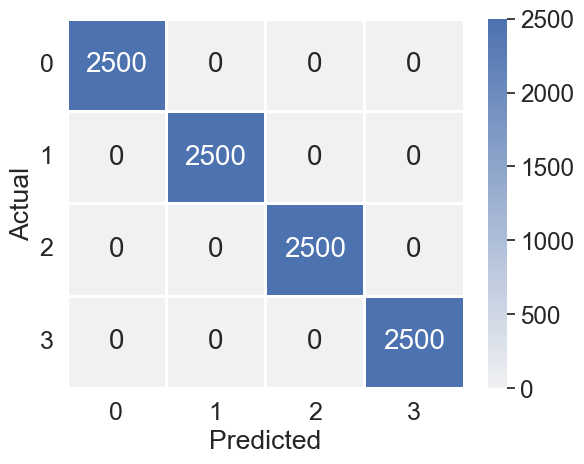

In [13]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [14]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


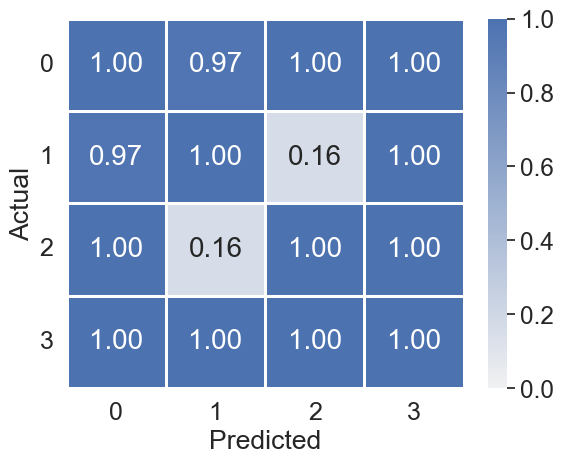

In [15]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [16]:
trainer = {}
sampler = {}

In [17]:
from gnn_boundary import Trainer

In [18]:
from utility_functions import *

In [19]:
def hyperparameterBoundary(max_nodes, lr, target_size, cls_1 = 0, cls_2 = 1):
    cls_1, cls_2 = cls_1, cls_2
    trainer[cls_1, cls_2] = Trainer(
        sampler=(s := GraphSampler(
            max_nodes=max_nodes,
            temperature=0.5,
            num_node_cls=3,#len(dataset.NODE_CLS),
            learn_node_feat=True
        )),
        discriminator=model,
        criterion=WeightedCriterion([
            dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
                classes=[cls_1, cls_2], alpha=1, beta=2
            ), weight=25),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
            dict(key="logits", criterion=MeanPenalty(), weight=1),
            dict(key="omega", criterion=NormPenalty(order=1), weight=1),
            dict(key="omega", criterion=NormPenalty(order=2), weight=1),
            # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
            # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
            dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
        ]),
        optimizer=(o := torch.optim.SGD(s.parameters(), lr=lr)),
        scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
        dataset=dataset,
        budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    )
    
    trainer[cls_1, cls_2].train(
        iterations=1000,
        target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
        target_size= target_size,
        w_budget_init=1,
        w_budget_inc=1.1,
        w_budget_dec=0.95,
        k_samples=16
    )

    explain_graph = trainer[cls_1, cls_2].evaluate(threshold=0.5, show=False)
    graph = dataset.convertNxToData(explain_graph)
    return graph
    


In [20]:
max_nodes_li = [10,15, 20, 25]
lr_li = [0.5,0.05, 0.005]
target_size_li = [15,25,30]

pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]

In [21]:
def indicator(prob, max_prob):
    if prob < max_prob:
        return 1
    else: 
        return 0

def criteria_function2(logits, all_probs,class_1, class_2):
    logits = [logit.item() for logit in logits]
    all_probs = [prob.item() for prob in all_probs]
    max_prob = max(all_probs)
    
    alpha = 1
    beta = 2
    sum_1 = 0
    sum_2 = 0
    for i in range(len(all_probs)):
        if i != class_1 and i != class_2:
            sum_1 += logits[i]*all_probs[i]**2
        else:
            sum_2 += logits[i]*(1-all_probs[i])**2*indicator(all_probs[i], max_prob)
    return beta * sum_1 -alpha* sum_2

In [22]:
#criteria_function = lambda x,y: (1-x)**2 + (1-y)**2
#color_dict = {(0,0,1):"red",(0,1,0):"blue",(1,0,0):"black"}
for pair in pairs:
    class_1, class_2 = pair
    print("\n##################")
    print(f"class{class_1} class{class_2}")
    best_probs = None
    best_logits = None
    best_graph = None
    best_hyperparameters = (0,0,0)
    best_all_probs = None
    for max_nodes in max_nodes_li:
        for lr in lr_li:
            for target_size in target_size_li:
                try:
                    graph = hyperparameterBoundary(max_nodes = max_nodes,lr = lr, target_size = target_size, cls_1= class_1, cls_2= class_2)
                    probs = (model(graph)["probs"].squeeze()[class_1].item(),model(graph)["probs"].squeeze()[class_2].item())
                    print(f"MN: {max_nodes} LR: {lr} TS: {target_size} Probs: {probs}")

                    all_probs = model(graph)["probs"].squeeze()
                    logits = model(graph)["logits"].squeeze()
                    print(f"all probs: {all_probs}")
                    if best_probs == None or criteria_function2(best_logits, best_all_probs, class_1,class_2) > (loss := criteria_function2(logits, all_probs, class_1, class_2)):
                        best_probs = probs
                        best_graph = graph
                        best_hyperparameters = (max_nodes, lr, target_size)
                        best_all_probs = all_probs
                        best_logits = logits
                    print(f"loss {loss}")
                except Exception as e:
                    if str(e) == "Empty graph!":
                        print("Caught an Empty graph exception")
                        print(f"MN: {max_nodes} LR: {lr} TS: {target_size}")
    

    print("********best result*********")
    print(best_probs)
    print(best_hyperparameters)
    print(best_all_probs)
    printGraph(best_graph, f"./images/multi_grid_class_{class_1}_class_{class_2}", clear_figure = True)



##################
class0 class1


100%|██████████| 1000/1000 [00:21<00:00, 46.12it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.04945029318332672, 0.02026049792766571)
all probs: tensor([0.0495, 0.0203, 0.0409, 0.8894], grad_fn=<SqueezeBackward0>)


 12%|█▏        | 124/1000 [00:08<00:57, 15.20it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.03432822227478027, 0.03517632186412811)
all probs: tensor([0.0343, 0.0352, 0.0125, 0.9180], grad_fn=<SqueezeBackward0>)
loss 6.351809987896784


  7%|▋         | 68/1000 [00:01<00:26, 35.75it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.044556040316820145, 0.03125457465648651)
all probs: tensor([0.0446, 0.0313, 0.0480, 0.8762], grad_fn=<SqueezeBackward0>)
loss 6.11536374786499


 25%|██▍       | 248/1000 [00:06<00:20, 36.74it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.06319178640842438, 0.027987059205770493)
all probs: tensor([0.0632, 0.0280, 0.1260, 0.7828], grad_fn=<SqueezeBackward0>)
loss 5.63828881656271


 38%|███▊      | 382/1000 [00:07<00:12, 47.95it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.05105244740843773, 0.023706484586000443)
all probs: tensor([0.0511, 0.0237, 0.0818, 0.8434], grad_fn=<SqueezeBackward0>)
loss 6.203497150038204


  7%|▋         | 73/1000 [00:01<00:18, 49.02it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.07978293299674988, 0.030868060886859894)
all probs: tensor([0.0798, 0.0309, 0.1271, 0.7623], grad_fn=<SqueezeBackward0>)
loss 5.216322462433494


100%|██████████| 1000/1000 [00:19<00:00, 50.83it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.08394084125757217, 0.0096540916711092)
all probs: tensor([0.0839, 0.0097, 0.6691, 0.2373], grad_fn=<SqueezeBackward0>)
loss 5.536825100656192


 65%|██████▌   | 654/1000 [00:12<00:06, 51.30it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.07907868176698685, 0.34441548585891724)
all probs: tensor([0.0791, 0.3444, 0.0425, 0.5340], grad_fn=<SqueezeBackward0>)
loss 2.509667572253298


100%|██████████| 1000/1000 [00:19<00:00, 52.38it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.057044073939323425, 0.03191236034035683)
all probs: tensor([0.0570, 0.0319, 0.0863, 0.8247], grad_fn=<SqueezeBackward0>)
loss 5.701951233367024


100%|██████████| 1000/1000 [00:20<00:00, 49.18it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.009916641749441624, 0.007882636971771717)
all probs: tensor([0.0099, 0.0079, 0.0074, 0.9748], grad_fn=<SqueezeBackward0>)
loss 9.335044680213093


 87%|████████▋ | 873/1000 [00:17<00:02, 49.90it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.006089287344366312, 0.9906807541847229)
all probs: tensor([6.0893e-03, 9.9068e-01, 1.5372e-05, 3.2146e-03],
       grad_fn=<SqueezeBackward0>)
loss 4.860013836566959


 30%|███       | 305/1000 [00:06<00:14, 49.62it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.021366344764828682, 0.023140277713537216)
all probs: tensor([0.0214, 0.0231, 0.0073, 0.9481], grad_fn=<SqueezeBackward0>)
loss 7.358099136298815


100%|█████████▉| 999/1000 [00:20<00:00, 49.46it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.0502406470477581, 0.01710897870361805)
all probs: tensor([0.0502, 0.0171, 0.0528, 0.8799], grad_fn=<SqueezeBackward0>)
loss 6.6485168722395045


  2%|▏         | 24/1000 [00:00<00:26, 37.19it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.032111506909132004, 0.487870991230011)
all probs: tensor([0.0321, 0.4879, 0.0045, 0.4755], grad_fn=<SqueezeBackward0>)
loss 3.4133758478255993


100%|██████████| 1000/1000 [00:20<00:00, 47.93it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.6434881687164307, 0.003221492050215602)
all probs: tensor([0.6435, 0.0032, 0.0489, 0.3044], grad_fn=<SqueezeBackward0>)
loss 5.9115429123532515


100%|██████████| 1000/1000 [00:22<00:00, 43.76it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.02789200283586979, 0.010478830896317959)
all probs: tensor([0.0279, 0.0105, 0.0193, 0.9423], grad_fn=<SqueezeBackward0>)
loss 7.905115582062555


100%|██████████| 1000/1000 [00:23<00:00, 41.97it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.0004874377336818725, 0.9925956130027771)
all probs: tensor([4.8744e-04, 9.9260e-01, 7.7306e-06, 6.9093e-03],
       grad_fn=<SqueezeBackward0>)
loss 6.580104645823326


 15%|█▍        | 146/1000 [00:03<00:19, 44.73it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.9314995408058167, 0.04555051028728485)
all probs: tensor([0.9315, 0.0456, 0.0050, 0.0180], grad_fn=<SqueezeBackward0>)
loss 3.9849788193422366


100%|██████████| 1000/1000 [00:30<00:00, 32.44it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.006514497566968203, 0.0037463237531483173)
all probs: tensor([0.0065, 0.0037, 0.0037, 0.9861], grad_fn=<SqueezeBackward0>)
loss 10.54544079715833


100%|██████████| 1000/1000 [00:30<00:00, 32.68it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (6.583740628229862e-07, 4.589381825959027e-12)
all probs: tensor([6.5837e-07, 4.5894e-12, 1.0000e+00, 1.8897e-06],
       grad_fn=<SqueezeBackward0>)
loss 40.34073673314974


  7%|▋         | 69/1000 [00:02<00:27, 33.58it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.9929755926132202, 2.4721357476664707e-05)
all probs: tensor([9.9298e-01, 2.4721e-05, 1.9634e-03, 5.0362e-03],
       grad_fn=<SqueezeBackward0>)
loss 10.246984430895832


100%|██████████| 1000/1000 [00:23<00:00, 42.60it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.01272653043270111, 0.0052880956791341305)
all probs: tensor([0.0127, 0.0053, 0.0056, 0.9764], grad_fn=<SqueezeBackward0>)
loss 9.486944166487657


100%|██████████| 1000/1000 [00:29<00:00, 33.50it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (2.535872383780546e-16, 8.152416464867668e-26)
all probs: tensor([2.5359e-16, 8.1524e-26, 1.0000e+00, 6.0686e-16],
       grad_fn=<SqueezeBackward0>)
loss 93.67972052097319


 17%|█▋        | 171/1000 [00:04<00:20, 39.50it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.7305870056152344, 0.06784874945878983)
all probs: tensor([0.7306, 0.0678, 0.0064, 0.1952], grad_fn=<SqueezeBackward0>)
loss 3.5218289887839886


 28%|██▊       | 283/1000 [00:07<00:18, 39.52it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.6977038979530334, 1.7793372535379604e-05)
all probs: tensor([6.9770e-01, 1.7793e-05, 2.9933e-01, 2.9526e-03],
       grad_fn=<SqueezeBackward0>)
loss 11.161967979284675


 63%|██████▎   | 632/1000 [00:14<00:08, 42.38it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.0010886837262660265, 0.9886201620101929)
all probs: tensor([1.0887e-03, 9.8862e-01, 2.1452e-06, 1.0289e-02],
       grad_fn=<SqueezeBackward0>)
loss 5.752217170237899


 14%|█▎        | 137/1000 [00:03<00:21, 40.25it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.006101928651332855, 0.005480602383613586)
all probs: tensor([0.0061, 0.0055, 0.0054, 0.9830], grad_fn=<SqueezeBackward0>)
loss 10.22430923782764


100%|██████████| 1000/1000 [00:27<00:00, 36.86it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (1.955300831468776e-06, 0.9997784495353699)
all probs: tensor([1.9553e-06, 9.9978e-01, 1.3964e-11, 2.1971e-04],
       grad_fn=<SqueezeBackward0>)
loss 10.783281487192703


100%|██████████| 1000/1000 [00:28<00:00, 34.70it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.0013886061497032642, 0.0008564823656342924)
all probs: tensor([1.3886e-03, 8.5648e-04, 2.7454e-04, 9.9748e-01],
       grad_fn=<SqueezeBackward0>)
loss 13.620900533805589


  2%|▏         | 16/1000 [00:01<01:41,  9.74it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.04523405060172081, 0.5503020286560059)
all probs: tensor([4.5234e-02, 5.5030e-01, 5.3394e-04, 4.0393e-01],
       grad_fn=<SqueezeBackward0>)
loss 3.520467045877943


100%|██████████| 1000/1000 [00:26<00:00, 37.64it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.9974049925804138, 1.0009695188273326e-06)
all probs: tensor([9.9740e-01, 1.0010e-06, 3.0751e-04, 2.2865e-03],
       grad_fn=<SqueezeBackward0>)
loss 13.539736146279923


 48%|████▊     | 480/1000 [00:13<00:14, 35.99it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (6.66578947529535e-14, 1.0)
all probs: tensor([6.6658e-14, 1.0000e+00, 3.0076e-17, 9.9342e-10],
       grad_fn=<SqueezeBackward0>)
loss 25.69894409179345


 73%|███████▎  | 730/1000 [00:22<00:08, 32.26it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (4.932312891448021e-10, 0.9999992847442627)
all probs: tensor([4.9323e-10, 1.0000e+00, 1.6119e-14, 7.2063e-07],
       grad_fn=<SqueezeBackward0>)
loss 17.96722791805593


 85%|████████▌ | 853/1000 [00:27<00:04, 31.35it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.8500326871871948, 0.008577074855566025)
all probs: tensor([0.8500, 0.0086, 0.0174, 0.1240], grad_fn=<SqueezeBackward0>)
loss 5.243516483170125


 46%|████▌     | 460/1000 [00:15<00:18, 29.16it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.01504821889102459, 0.00030068022897467017)
all probs: tensor([1.5048e-02, 3.0068e-04, 9.7834e-01, 6.3081e-03],
       grad_fn=<SqueezeBackward0>)
loss 12.124279990564627


 33%|███▎      | 331/1000 [00:11<00:23, 28.91it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.007852605544030666, 0.7372912764549255)
all probs: tensor([7.8526e-03, 7.3729e-01, 2.2207e-04, 2.5463e-01],
       grad_fn=<SqueezeBackward0>)
loss 5.81917669728208
********best result*********
(0.07907868176698685, 0.34441548585891724)
(10, 0.005, 25)
tensor([0.0791, 0.3444, 0.0425, 0.5340], grad_fn=<SqueezeBackward0>)

##################
class0 class2


100%|██████████| 1000/1000 [00:20<00:00, 48.46it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.06000302731990814, 0.02968486398458481)
all probs: tensor([0.0600, 0.0410, 0.0297, 0.8694], grad_fn=<SqueezeBackward0>)
loss 5.81917669728208


 21%|██        | 208/1000 [00:03<00:14, 54.64it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.07464122772216797, 0.09274415671825409)
all probs: tensor([0.0746, 0.0281, 0.0927, 0.8046], grad_fn=<SqueezeBackward0>)
loss 4.0726653276085685


  1%|▏         | 13/1000 [00:00<00:21, 45.90it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.03672116994857788, 0.051679521799087524)
all probs: tensor([0.0367, 0.0226, 0.0517, 0.8890], grad_fn=<SqueezeBackward0>)
loss 5.726032992608149


 76%|███████▋  | 763/1000 [00:14<00:04, 53.02it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.0676771029829979, 0.08927369862794876)
all probs: tensor([0.0677, 0.0285, 0.0893, 0.8146], grad_fn=<SqueezeBackward0>)
loss 4.2481678945752614


  9%|▉         | 90/1000 [00:01<00:17, 53.41it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.05328034237027168, 0.06571507453918457)
all probs: tensor([0.0533, 0.0211, 0.0657, 0.8599], grad_fn=<SqueezeBackward0>)
loss 4.964492035242653


 40%|████      | 400/1000 [00:07<00:11, 52.33it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.07108031213283539, 0.06724226474761963)
all probs: tensor([0.0711, 0.0439, 0.0672, 0.8178], grad_fn=<SqueezeBackward0>)
loss 4.585766808197146


 12%|█▎        | 125/1000 [00:03<00:22, 39.60it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.08406767249107361, 0.111369289457798)
all probs: tensor([0.0841, 0.0386, 0.1114, 0.7660], grad_fn=<SqueezeBackward0>)
loss 3.643806545312884


100%|██████████| 1000/1000 [00:20<00:00, 48.55it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.0260824803262949, 0.04680750519037247)
all probs: tensor([0.0261, 0.0228, 0.0468, 0.9043], grad_fn=<SqueezeBackward0>)
loss 6.251055396248165


 26%|██▌       | 259/1000 [00:05<00:14, 50.51it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.040692053735256195, 0.008143718354403973)
all probs: tensor([0.0407, 0.7471, 0.0081, 0.2041], grad_fn=<SqueezeBackward0>)
loss 7.156889628039571


  0%|          | 4/1000 [00:00<00:46, 21.34it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.06134980171918869, 0.057417284697294235)
all probs: tensor([0.0613, 0.0475, 0.0574, 0.8337], grad_fn=<SqueezeBackward0>)
loss 4.998998736032833


  1%|          | 9/1000 [00:00<00:31, 31.76it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.011910760775208473, 0.005146268755197525)
all probs: tensor([0.0119, 0.0122, 0.0051, 0.9708], grad_fn=<SqueezeBackward0>)
loss 9.617942671238541


 48%|████▊     | 481/1000 [00:10<00:11, 45.74it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.9999997615814209, 2.3123679682157672e-07)
all probs: tensor([1.0000e+00, 2.2864e-13, 2.3124e-07, 2.5585e-09],
       grad_fn=<SqueezeBackward0>)
loss 14.657038585884225


 18%|█▊        | 177/1000 [00:05<00:23, 35.02it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.03548220917582512, 0.0277501679956913)
all probs: tensor([0.0355, 0.0140, 0.0278, 0.9228], grad_fn=<SqueezeBackward0>)
loss 6.526671438519547


  6%|▌         | 60/1000 [00:01<00:26, 35.19it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.728687584400177, 0.06842678785324097)
all probs: tensor([0.7287, 0.0022, 0.0684, 0.2006], grad_fn=<SqueezeBackward0>)
loss 2.612958140337072


 61%|██████    | 608/1000 [00:14<00:09, 42.10it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.020049329847097397, 0.014752392657101154)
all probs: tensor([0.0200, 0.0161, 0.0148, 0.9491], grad_fn=<SqueezeBackward0>)
loss 7.915270949112071


 98%|█████████▊| 975/1000 [00:21<00:00, 44.41it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (4.042847220192547e-12, 1.9849380927979e-13)
all probs: tensor([4.0428e-12, 1.0000e+00, 1.9849e-13, 2.1718e-07],
       grad_fn=<SqueezeBackward0>)
loss 55.48208621286568


  6%|▌         | 58/1000 [00:01<00:22, 42.25it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (1.1477731476361441e-07, 0.9999994039535522)
all probs: tensor([1.1478e-07, 4.3182e-12, 1.0000e+00, 5.3590e-07],
       grad_fn=<SqueezeBackward0>)
loss 15.475873255599536


 17%|█▋        | 173/1000 [00:04<00:20, 40.65it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.025295184925198555, 0.020453060045838356)
all probs: tensor([0.0253, 0.0147, 0.0205, 0.9395], grad_fn=<SqueezeBackward0>)
loss 7.275293202713316


100%|██████████| 1000/1000 [00:25<00:00, 38.93it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.995372474193573, 0.001644899952225387)
all probs: tensor([9.9537e-01, 4.8334e-06, 1.6449e-03, 2.9777e-03],
       grad_fn=<SqueezeBackward0>)
loss 5.733870261674425


100%|██████████| 1000/1000 [00:24<00:00, 40.10it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.00018398485553916544, 2.3301609530790302e-07)
all probs: tensor([1.8398e-04, 9.9753e-01, 2.3302e-07, 2.2872e-03],
       grad_fn=<SqueezeBackward0>)
loss 23.8518352492838


  1%|          | 11/1000 [00:00<00:52, 18.88it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.03463485836982727, 0.09726373851299286)
all probs: tensor([0.0346, 0.0034, 0.0973, 0.8647], grad_fn=<SqueezeBackward0>)
loss 5.073100348089779


 88%|████████▊ | 880/1000 [00:22<00:03, 40.00it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.02123383805155754, 0.04615833982825279)
all probs: tensor([0.0212, 0.0065, 0.0462, 0.9261], grad_fn=<SqueezeBackward0>)
loss 6.4938490668450015


 10%|▉         | 97/1000 [00:02<00:22, 39.68it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.9997374415397644, 0.00022324937162920833)
all probs: tensor([9.9974e-01, 8.6593e-08, 2.2325e-04, 3.9208e-05],
       grad_fn=<SqueezeBackward0>)
loss 7.840666136440338


 20%|██        | 202/1000 [00:04<00:19, 41.40it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.01280944049358368, 0.7970362305641174)
all probs: tensor([1.2809e-02, 4.3326e-04, 7.9704e-01, 1.8972e-01],
       grad_fn=<SqueezeBackward0>)
loss 4.22021360736138


 84%|████████▎ | 836/1000 [00:22<00:04, 36.40it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.00016403818153776228, 0.999420166015625)
all probs: tensor([1.6404e-04, 1.1615e-07, 9.9942e-01, 4.1570e-04],
       grad_fn=<SqueezeBackward0>)
loss 8.069963984360614


 24%|██▍       | 240/1000 [00:06<00:19, 39.44it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (8.507086749887094e-05, 0.9996343851089478)
all probs: tensor([8.5071e-05, 1.9949e-08, 9.9963e-01, 2.8051e-04],
       grad_fn=<SqueezeBackward0>)
loss 8.49267907348505


 13%|█▎        | 129/1000 [00:04<00:27, 31.62it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (4.059663744765147e-15, 1.0)
all probs: tensor([4.0597e-15, 1.4288e-21, 1.0000e+00, 1.5577e-14],
       grad_fn=<SqueezeBackward0>)
loss 33.806438446044645


  0%|          | 4/1000 [00:01<04:38,  3.58it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.030956871807575226, 0.6390682458877563)
all probs: tensor([0.0310, 0.0009, 0.6391, 0.3290], grad_fn=<SqueezeBackward0>)
loss 3.3806571427288894


 77%|███████▋  | 769/1000 [00:23<00:07, 32.54it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.9999977350234985, 1.2178345514257671e-06)
all probs: tensor([1.0000e+00, 1.0147e-06, 1.2178e-06, 1.8347e-08],
       grad_fn=<SqueezeBackward0>)
loss 16.459241832012413


 35%|███▍      | 346/1000 [00:10<00:20, 31.54it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.9999858140945435, 1.3202208720031194e-05)
all probs: tensor([9.9999e-01, 2.3142e-10, 1.3202e-05, 9.0397e-07],
       grad_fn=<SqueezeBackward0>)
loss 10.433019766652983


 98%|█████████▊| 981/1000 [00:28<00:00, 35.02it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.05237198993563652, 0.22510771453380585)
all probs: tensor([0.0524, 0.0045, 0.2251, 0.7180], grad_fn=<SqueezeBackward0>)
loss 3.6071305918864653


 45%|████▍     | 449/1000 [00:12<00:14, 36.96it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.009995995089411736, 0.006644178181886673)
all probs: tensor([0.0100, 0.0030, 0.0066, 0.9804], grad_fn=<SqueezeBackward0>)
loss 9.491938414880915


 10%|▉         | 98/1000 [00:03<00:28, 31.20it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.9985930323600769, 0.0008600810542702675)
all probs: tensor([9.9859e-01, 3.0743e-07, 8.6008e-04, 5.4653e-04],
       grad_fn=<SqueezeBackward0>)
loss 6.097565528991346


100%|██████████| 1000/1000 [00:26<00:00, 37.77it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.01735500991344452, 0.02134697698056698)
all probs: tensor([0.0174, 0.0164, 0.0213, 0.9449], grad_fn=<SqueezeBackward0>)
loss 7.651380944988425


 50%|█████     | 504/1000 [00:15<00:15, 33.01it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.8709438443183899, 0.002130814827978611)
all probs: tensor([0.8709, 0.0028, 0.0021, 0.1242], grad_fn=<SqueezeBackward0>)
loss 7.835269879463575


 21%|██        | 210/1000 [00:07<00:27, 28.90it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.023172613233327866, 0.5324068665504456)
all probs: tensor([2.3173e-02, 4.6785e-04, 5.3241e-01, 4.4395e-01],
       grad_fn=<SqueezeBackward0>)
loss 3.8613519871941575
********best result*********
(0.728687584400177, 0.06842678785324097)
(15, 0.05, 25)
tensor([0.7287, 0.0022, 0.0684, 0.2006], grad_fn=<SqueezeBackward0>)

##################
class0 class3


100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.06385459005832672, 0.8424649238586426)
all probs: tensor([0.0639, 0.0243, 0.0694, 0.8425], grad_fn=<SqueezeBackward0>)
loss 3.8613519871941575


  2%|▏         | 19/1000 [00:00<00:21, 44.73it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.6547485589981079, 0.31855306029319763)
all probs: tensor([0.6547, 0.0050, 0.0217, 0.3186], grad_fn=<SqueezeBackward0>)
loss 0.7869108782177927


  1%|          | 6/1000 [00:00<00:23, 41.78it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.03639080747961998, 0.9003318548202515)
all probs: tensor([0.0364, 0.0167, 0.0466, 0.9003], grad_fn=<SqueezeBackward0>)
loss 3.790928677019212


  8%|▊         | 76/1000 [00:01<00:17, 52.29it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.04425259307026863, 0.8834738731384277)
all probs: tensor([0.0443, 0.0226, 0.0497, 0.8835], grad_fn=<SqueezeBackward0>)
loss 3.509552346025039


  0%|          | 5/1000 [00:00<00:26, 38.20it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.048139557242393494, 0.8942620158195496)
all probs: tensor([0.0481, 0.0196, 0.0379, 0.8943], grad_fn=<SqueezeBackward0>)
loss 3.5036734198704567


  0%|          | 1/1000 [00:00<00:49, 20.28it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.006959619931876659, 0.9504675269126892)
all probs: tensor([0.0070, 0.0351, 0.0075, 0.9505], grad_fn=<SqueezeBackward0>)
loss 6.206246797550447


 34%|███▍      | 342/1000 [00:07<00:14, 45.64it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.08252831548452377, 0.8069749474525452)
all probs: tensor([0.0825, 0.0270, 0.0835, 0.8070], grad_fn=<SqueezeBackward0>)
loss 2.477602072842155


  2%|▎         | 25/1000 [00:00<00:20, 47.59it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.9158667922019958, 0.06143349036574364)
all probs: tensor([0.9159, 0.0012, 0.0215, 0.0614], grad_fn=<SqueezeBackward0>)
loss 2.1751548033696966


  0%|          | 2/1000 [00:00<00:37, 26.63it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.018364954739809036, 0.9309987425804138)
all probs: tensor([0.0184, 0.0254, 0.0252, 0.9310], grad_fn=<SqueezeBackward0>)
loss 4.830138765144288


100%|██████████| 1000/1000 [00:22<00:00, 43.92it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (1.5981339538400083e-17, 7.153823749712679e-16)
all probs: tensor([1.5981e-17, 7.5755e-26, 1.0000e+00, 7.1538e-16],
       grad_fn=<SqueezeBackward0>)
loss 73.54882680624718


  1%|          | 12/1000 [00:00<00:30, 32.15it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.0008957883110269904, 0.0004940574872307479)
all probs: tensor([8.9579e-04, 2.8246e-05, 9.9858e-01, 4.9406e-04],
       grad_fn=<SqueezeBackward0>)
loss 14.609635579808781


  1%|          | 11/1000 [00:00<00:31, 31.17it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.0005674197454936802, 6.368701633618912e-06)
all probs: tensor([5.6742e-04, 4.6483e-10, 9.9943e-01, 6.3687e-06],
       grad_fn=<SqueezeBackward0>)
loss 19.428985316475412


100%|██████████| 1000/1000 [00:24<00:00, 40.14it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.035488925874233246, 0.3813580870628357)
all probs: tensor([0.0355, 0.0014, 0.5817, 0.3814], grad_fn=<SqueezeBackward0>)
loss 3.406335981097276


 20%|██        | 202/1000 [00:04<00:18, 42.23it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.6058105826377869, 0.37036052346229553)
all probs: tensor([0.6058, 0.0021, 0.0217, 0.3704], grad_fn=<SqueezeBackward0>)
loss 0.8054219896734022


  1%|          | 9/1000 [00:00<00:31, 31.46it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.029327785596251488, 0.9483010768890381)
all probs: tensor([0.0293, 0.0176, 0.0047, 0.9483], grad_fn=<SqueezeBackward0>)
loss 4.925401597808522


100%|██████████| 1000/1000 [00:24<00:00, 40.58it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (6.944124823050726e-24, 4.0130417002004384e-22)
all probs: tensor([6.9441e-24, 1.1985e-33, 1.0000e+00, 4.0130e-22],
       grad_fn=<SqueezeBackward0>)
loss 102.59147119522095


  6%|▌         | 55/1000 [00:01<00:28, 33.47it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.051311273127794266, 0.7317491173744202)
all probs: tensor([0.0513, 0.0041, 0.2128, 0.7317], grad_fn=<SqueezeBackward0>)
loss 3.173859948139436


 50%|████▉     | 498/1000 [00:12<00:12, 40.10it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.10797525942325592, 0.6924386620521545)
all probs: tensor([0.1080, 0.0577, 0.1419, 0.6924], grad_fn=<SqueezeBackward0>)
loss 1.7836682832171948


  1%|          | 11/1000 [00:00<01:04, 15.22it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.7922515273094177, 0.17227713763713837)
all probs: tensor([0.7923, 0.0019, 0.0336, 0.1723], grad_fn=<SqueezeBackward0>)
loss 1.4285955815454987


  1%|▏         | 13/1000 [00:00<00:58, 16.81it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.017435582354664803, 0.9602597951889038)
all probs: tensor([0.0174, 0.0101, 0.0122, 0.9603], grad_fn=<SqueezeBackward0>)
loss 5.185682427682618


  2%|▏         | 15/1000 [00:00<00:48, 20.49it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.010884036310017109, 0.5973907709121704)
all probs: tensor([0.0109, 0.3903, 0.0014, 0.5974], grad_fn=<SqueezeBackward0>)
loss 5.3310285788475635


100%|██████████| 1000/1000 [00:24<00:00, 40.82it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.9998069405555725, 3.2720447052270174e-05)
all probs: tensor([9.9981e-01, 2.3988e-08, 1.6030e-04, 3.2720e-05],
       grad_fn=<SqueezeBackward0>)
loss 9.575874751226968


  3%|▎         | 33/1000 [00:01<00:31, 30.57it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.9992737174034119, 0.0003629770071711391)
all probs: tensor([9.9927e-01, 1.4814e-07, 3.6315e-04, 3.6298e-04],
       grad_fn=<SqueezeBackward0>)
loss 6.85737829010167


  8%|▊         | 81/1000 [00:02<00:27, 32.84it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.05116995424032211, 0.8938371539115906)
all probs: tensor([0.0512, 0.0041, 0.0509, 0.8938], grad_fn=<SqueezeBackward0>)
loss 3.5660067295124787


100%|██████████| 1000/1000 [00:30<00:00, 33.25it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.3692283034324646, 0.4580517113208771)
all probs: tensor([0.3692, 0.0037, 0.1690, 0.4581], grad_fn=<SqueezeBackward0>)
loss 0.5560604644948108


100%|██████████| 1000/1000 [00:34<00:00, 29.36it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.013499617576599121, 0.1848895102739334)
all probs: tensor([0.0135, 0.8000, 0.0016, 0.1849], grad_fn=<SqueezeBackward0>)
loss 5.132818727625632


 27%|██▋       | 270/1000 [00:08<00:21, 33.47it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.013700049370527267, 0.9554276466369629)
all probs: tensor([0.0137, 0.0285, 0.0024, 0.9554], grad_fn=<SqueezeBackward0>)
loss 6.1064647265743845


100%|██████████| 1000/1000 [00:30<00:00, 32.82it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.7557940483093262, 0.2399570792913437)
all probs: tensor([7.5579e-01, 2.7390e-04, 3.9751e-03, 2.3996e-01],
       grad_fn=<SqueezeBackward0>)
loss 1.8229280091179247


 88%|████████▊ | 881/1000 [00:26<00:03, 33.72it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.0002619382576085627, 0.0036058162804692984)
all probs: tensor([2.6194e-04, 9.9613e-01, 1.4557e-07, 3.6058e-03],
       grad_fn=<SqueezeBackward0>)
loss 13.809515843830159


100%|██████████| 1000/1000 [00:29<00:00, 34.17it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.0007791126845404506, 0.9976947903633118)
all probs: tensor([7.7911e-04, 8.2580e-04, 7.0030e-04, 9.9769e-01],
       grad_fn=<SqueezeBackward0>)
loss 9.354309892166848


100%|██████████| 1000/1000 [00:30<00:00, 32.46it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.9999722242355347, 1.7399918306182371e-06)
all probs: tensor([9.9997e-01, 3.0510e-09, 2.5940e-05, 1.7400e-06],
       grad_fn=<SqueezeBackward0>)
loss 12.772719743407526


 10%|█         | 102/1000 [00:03<00:33, 26.90it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.015032310970127583, 0.9814884662628174)
all probs: tensor([0.0150, 0.0020, 0.0014, 0.9815], grad_fn=<SqueezeBackward0>)
loss 6.229201424409534


 19%|█▉        | 191/1000 [00:07<00:31, 25.98it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.007169895339757204, 0.9859505295753479)
all probs: tensor([0.0072, 0.0033, 0.0036, 0.9860], grad_fn=<SqueezeBackward0>)
loss 6.579072803307933


100%|██████████| 1000/1000 [00:29<00:00, 33.84it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.06242777034640312, 0.48569998145103455)
all probs: tensor([0.0624, 0.0106, 0.4413, 0.4857], grad_fn=<SqueezeBackward0>)
loss 2.1654187100126756


100%|██████████| 1000/1000 [00:29<00:00, 34.05it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.008272684179246426, 0.9739130139350891)
all probs: tensor([0.0083, 0.0022, 0.0156, 0.9739], grad_fn=<SqueezeBackward0>)
loss 5.976786852805783


  5%|▍         | 46/1000 [00:02<00:47, 20.18it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (2.8856231438112445e-05, 0.000974335940554738)
all probs: tensor([2.8856e-05, 9.9900e-01, 1.6722e-09, 9.7434e-04],
       grad_fn=<SqueezeBackward0>)
loss 17.367016782555027
********best result*********
(0.3692283034324646, 0.4580517113208771)
(20, 0.005, 15)
tensor([0.3692, 0.0037, 0.1690, 0.4581], grad_fn=<SqueezeBackward0>)

##################
class1 class2


100%|██████████| 1000/1000 [00:21<00:00, 47.60it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.17782215774059296, 0.0227408055216074)
all probs: tensor([0.0577, 0.1778, 0.0227, 0.7417], grad_fn=<SqueezeBackward0>)
loss 17.367016782555027


100%|██████████| 1000/1000 [00:22<00:00, 44.25it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (1.0, 5.12609409068246e-19)
all probs: tensor([8.1575e-18, 1.0000e+00, 5.1261e-19, 1.6582e-10],
       grad_fn=<SqueezeBackward0>)
loss 36.400054931640625


100%|██████████| 1000/1000 [00:22<00:00, 44.02it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.6152160167694092, 0.019359072670340538)
all probs: tensor([0.0491, 0.6152, 0.0194, 0.3163], grad_fn=<SqueezeBackward0>)
loss 3.5815502752902355


100%|██████████| 1000/1000 [00:19<00:00, 50.71it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.03306623175740242, 0.035854585468769073)
all probs: tensor([0.0364, 0.0331, 0.0359, 0.8947], grad_fn=<SqueezeBackward0>)
loss 6.336070539502645


100%|██████████| 1000/1000 [00:23<00:00, 43.00it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.053697213530540466, 0.16042982041835785)
all probs: tensor([0.1014, 0.0537, 0.1604, 0.6844], grad_fn=<SqueezeBackward0>)
loss 3.5693155948246935


100%|██████████| 1000/1000 [00:19<00:00, 50.84it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.03328133001923561, 0.05075623095035553)
all probs: tensor([0.0571, 0.0333, 0.0508, 0.8588], grad_fn=<SqueezeBackward0>)
loss 5.888209583318051


100%|██████████| 1000/1000 [00:18<00:00, 52.82it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.0392988845705986, 0.10862471908330917)
all probs: tensor([0.0761, 0.0393, 0.1086, 0.7760], grad_fn=<SqueezeBackward0>)
loss 4.597678229068729


100%|██████████| 1000/1000 [00:20<00:00, 48.93it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.050206221640110016, 0.09639483690261841)
all probs: tensor([0.0715, 0.0502, 0.0964, 0.7819], grad_fn=<SqueezeBackward0>)
loss 4.486595972893458


100%|██████████| 1000/1000 [00:20<00:00, 48.37it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.0195495393127203, 0.09250461310148239)
all probs: tensor([0.0257, 0.0195, 0.0925, 0.8623], grad_fn=<SqueezeBackward0>)
loss 5.680397017337505


100%|██████████| 1000/1000 [00:20<00:00, 49.07it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.011668898165225983, 0.019254446029663086)
all probs: tensor([0.0539, 0.0117, 0.0193, 0.9152], grad_fn=<SqueezeBackward0>)
loss 8.282627023059096


100%|██████████| 1000/1000 [00:24<00:00, 40.38it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.9847652912139893, 5.087460067443317e-06)
all probs: tensor([1.0048e-03, 9.8477e-01, 5.0875e-06, 1.4225e-02],
       grad_fn=<SqueezeBackward0>)
loss 11.12434324344676


100%|██████████| 1000/1000 [00:24<00:00, 41.25it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.006191154010593891, 0.011012752540409565)
all probs: tensor([0.0142, 0.0062, 0.0110, 0.9686], grad_fn=<SqueezeBackward0>)
loss 9.487746386538166


100%|██████████| 1000/1000 [00:21<00:00, 46.10it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.012829379178583622, 0.021453872323036194)
all probs: tensor([0.0245, 0.0128, 0.0215, 0.9412], grad_fn=<SqueezeBackward0>)
loss 7.987665210952496


100%|██████████| 1000/1000 [00:22<00:00, 44.44it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.0017742651980370283, 0.663895845413208)
all probs: tensor([0.0173, 0.0018, 0.6639, 0.3170], grad_fn=<SqueezeBackward0>)
loss 6.252454879566825


100%|██████████| 1000/1000 [00:21<00:00, 46.94it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.15476441383361816, 0.02917945757508278)
all probs: tensor([0.0621, 0.1548, 0.0292, 0.7540], grad_fn=<SqueezeBackward0>)
loss 4.785696511480542


100%|██████████| 1000/1000 [00:20<00:00, 48.89it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.012113845907151699, 0.04660194367170334)
all probs: tensor([0.0280, 0.0121, 0.0466, 0.9133], grad_fn=<SqueezeBackward0>)
loss 7.114038350144431


100%|██████████| 1000/1000 [00:21<00:00, 46.74it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (1.8759945955351947e-15, 1.0)
all probs: tensor([1.9639e-10, 1.8760e-15, 1.0000e+00, 1.6335e-09],
       grad_fn=<SqueezeBackward0>)
loss 33.836685180663935


100%|██████████| 1000/1000 [00:21<00:00, 46.79it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.1190531998872757, 0.03790557011961937)
all probs: tensor([0.0649, 0.1191, 0.0379, 0.7782], grad_fn=<SqueezeBackward0>)
loss 4.758616839131138


100%|██████████| 1000/1000 [00:24<00:00, 41.58it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (3.460331981841591e-06, 0.9768232107162476)
all probs: tensor([2.5844e-03, 3.4603e-06, 9.7682e-01, 2.0589e-02],
       grad_fn=<SqueezeBackward0>)
loss 11.914363172654221


100%|██████████| 1000/1000 [00:27<00:00, 35.95it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.005637576803565025, 0.0029201111756265163)
all probs: tensor([0.0079, 0.0056, 0.0029, 0.9835], grad_fn=<SqueezeBackward0>)
loss 10.977325849262586


100%|██████████| 1000/1000 [00:25<00:00, 38.56it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.02889106422662735, 0.005118505097925663)
all probs: tensor([0.0174, 0.0289, 0.0051, 0.9486], grad_fn=<SqueezeBackward0>)
loss 8.693429645933016


100%|██████████| 1000/1000 [00:24<00:00, 41.38it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (1.8012012992230098e-09, 0.9999116659164429)
all probs: tensor([1.6100e-05, 1.8012e-09, 9.9991e-01, 7.2229e-05],
       grad_fn=<SqueezeBackward0>)
loss 19.162710026216608


100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.012217902578413486, 0.007104175630956888)
all probs: tensor([0.0128, 0.0122, 0.0071, 0.9679], grad_fn=<SqueezeBackward0>)
loss 9.2473106172776


100%|██████████| 1000/1000 [00:26<00:00, 37.32it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.9771774411201477, 1.3977962225908414e-05)
all probs: tensor([1.8217e-03, 9.7718e-01, 1.3978e-05, 2.0987e-02],
       grad_fn=<SqueezeBackward0>)
loss 10.46685043165267


100%|██████████| 1000/1000 [00:24<00:00, 40.50it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.00960315577685833, 0.01126753631979227)
all probs: tensor([0.0166, 0.0096, 0.0113, 0.9626], grad_fn=<SqueezeBackward0>)
loss 9.013694743685953


100%|██████████| 1000/1000 [00:23<00:00, 42.05it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.9998736381530762, 5.408569703213573e-10)
all probs: tensor([7.8770e-07, 9.9987e-01, 5.4086e-10, 1.2556e-04],
       grad_fn=<SqueezeBackward0>)
loss 19.13372970024525


100%|██████████| 1000/1000 [00:22<00:00, 44.06it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.9557351469993591, 5.854170740349218e-05)
all probs: tensor([2.8008e-03, 9.5574e-01, 5.8542e-05, 4.1405e-02],
       grad_fn=<SqueezeBackward0>)
loss 9.408854575106009


100%|██████████| 1000/1000 [00:26<00:00, 38.29it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (6.75450501148589e-05, 0.0001847797102527693)
all probs: tensor([9.9579e-01, 6.7545e-05, 1.8478e-04, 3.9618e-03],
       grad_fn=<SqueezeBackward0>)
loss 18.202581106927795


100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.5654563307762146, 0.00025096506578847766)
all probs: tensor([1.2849e-03, 5.6546e-01, 2.5097e-04, 4.3301e-01],
       grad_fn=<SqueezeBackward0>)
loss 9.251594008401531


100%|██████████| 1000/1000 [00:26<00:00, 38.38it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.0009886068291962147, 0.0017222511814907193)
all probs: tensor([1.1466e-03, 9.8861e-04, 1.7223e-03, 9.9614e-01],
       grad_fn=<SqueezeBackward0>)
loss 13.258951031070884


100%|██████████| 1000/1000 [00:27<00:00, 35.98it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.000123775185784325, 0.004798070527613163)
all probs: tensor([8.8183e-01, 1.2378e-04, 4.7981e-03, 1.1325e-01],
       grad_fn=<SqueezeBackward0>)
loss 14.5099685350787


100%|██████████| 1000/1000 [00:26<00:00, 38.37it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.9990909099578857, 3.398361414497231e-08)
all probs: tensor([5.3256e-05, 9.9909e-01, 3.3984e-08, 8.5583e-04],
       grad_fn=<SqueezeBackward0>)
loss 15.694782533762474


100%|██████████| 1000/1000 [00:29<00:00, 34.25it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.9289808869361877, 0.00010114425822393969)
all probs: tensor([4.1166e-02, 9.2898e-01, 1.0114e-04, 2.9752e-02],
       grad_fn=<SqueezeBackward0>)
loss 10.04939404700962


100%|██████████| 1000/1000 [00:28<00:00, 35.49it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (2.3248372826856212e-07, 0.9972048401832581)
all probs: tensor([6.8893e-04, 2.3248e-07, 9.9720e-01, 2.1060e-03],
       grad_fn=<SqueezeBackward0>)
loss 14.233215534143692


100%|██████████| 1000/1000 [00:26<00:00, 37.19it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.8117600083351135, 0.0002807689306791872)
all probs: tensor([1.7793e-01, 8.1176e-01, 2.8077e-04, 1.0028e-02],
       grad_fn=<SqueezeBackward0>)
loss 9.590651250246344


100%|██████████| 1000/1000 [00:26<00:00, 37.17it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.9992755055427551, 3.030876030152285e-07)
all probs: tensor([1.0679e-04, 9.9928e-01, 3.0309e-07, 6.1745e-04],
       grad_fn=<SqueezeBackward0>)
loss 13.893297158193807
********best result*********
(0.053697213530540466, 0.16042982041835785)
(10, 0.05, 25)
tensor([0.1014, 0.0537, 0.1604, 0.6844], grad_fn=<SqueezeBackward0>)

##################
class1 class3


100%|██████████| 1000/1000 [00:19<00:00, 50.02it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.002556463470682502, 0.14923685789108276)
all probs: tensor([0.0481, 0.0026, 0.8002, 0.1492], grad_fn=<SqueezeBackward0>)
loss 13.893297158193807


 27%|██▋       | 267/1000 [00:05<00:14, 51.10it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.033451106399297714, 0.8987085819244385)
all probs: tensor([0.0249, 0.0335, 0.0430, 0.8987], grad_fn=<SqueezeBackward0>)
loss 3.911713355684368


100%|██████████| 1000/1000 [00:19<00:00, 51.01it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.05136376619338989, 0.864544153213501)
all probs: tensor([0.0400, 0.0514, 0.0441, 0.8645], grad_fn=<SqueezeBackward0>)
loss 3.3609071482947344


 38%|███▊      | 381/1000 [00:08<00:13, 44.65it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.009352549910545349, 0.3367500305175781)
all probs: tensor([0.6081, 0.0094, 0.0458, 0.3368], grad_fn=<SqueezeBackward0>)
loss 4.893492139171382


 28%|██▊       | 278/1000 [00:05<00:13, 52.51it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.017061872407794, 0.895226001739502)
all probs: tensor([0.0418, 0.0171, 0.0460, 0.8952], grad_fn=<SqueezeBackward0>)
loss 4.664280537119703


  1%|          | 11/1000 [00:00<00:20, 47.77it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.04450377821922302, 0.7853453159332275)
all probs: tensor([0.0799, 0.0445, 0.0902, 0.7853], grad_fn=<SqueezeBackward0>)
loss 3.1621200170219708


 48%|████▊     | 475/1000 [00:09<00:10, 51.89it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.29730674624443054, 0.5397231578826904)
all probs: tensor([0.1007, 0.2973, 0.0622, 0.5397], grad_fn=<SqueezeBackward0>)
loss 0.6425891306402206


 36%|███▌      | 356/1000 [00:06<00:12, 52.80it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.9749729633331299, 0.023386988788843155)
all probs: tensor([1.6057e-03, 9.7497e-01, 3.4244e-05, 2.3387e-02],
       grad_fn=<SqueezeBackward0>)
loss 2.6484096969412607


100%|██████████| 1000/1000 [00:19<00:00, 51.69it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.0637381300330162, 0.7804980874061584)
all probs: tensor([0.0714, 0.0637, 0.0844, 0.7805], grad_fn=<SqueezeBackward0>)
loss 2.7358255946740186


100%|██████████| 1000/1000 [00:21<00:00, 47.26it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.014702847227454185, 0.9499655365943909)
all probs: tensor([0.0168, 0.0147, 0.0185, 0.9500], grad_fn=<SqueezeBackward0>)
loss 5.222354410007804


100%|██████████| 1000/1000 [00:20<00:00, 48.29it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.009194059297442436, 0.9757547974586487)
all probs: tensor([0.0098, 0.0092, 0.0053, 0.9758], grad_fn=<SqueezeBackward0>)
loss 6.1920120917683645


  2%|▏         | 16/1000 [00:00<00:26, 37.41it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.0061182319186627865, 0.9738953709602356)
all probs: tensor([0.0096, 0.0061, 0.0104, 0.9739], grad_fn=<SqueezeBackward0>)
loss 6.33750656912531


 74%|███████▍  | 740/1000 [00:16<00:05, 45.93it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.015592116862535477, 0.8980198502540588)
all probs: tensor([0.0422, 0.0156, 0.0442, 0.8980], grad_fn=<SqueezeBackward0>)
loss 4.7896879109713195


 15%|█▌        | 154/1000 [00:03<00:21, 39.62it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.46311819553375244, 0.5129360556602478)
all probs: tensor([0.0195, 0.4631, 0.0045, 0.5129], grad_fn=<SqueezeBackward0>)
loss 0.5550564275254706


 21%|██        | 207/1000 [00:04<00:17, 46.22it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.006925696507096291, 0.814376950263977)
all probs: tensor([0.1607, 0.0069, 0.0180, 0.8144], grad_fn=<SqueezeBackward0>)
loss 5.958779381355672


 87%|████████▋ | 868/1000 [00:18<00:02, 45.89it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.057124197483062744, 0.7127214074134827)
all probs: tensor([0.0909, 0.0571, 0.1393, 0.7127], grad_fn=<SqueezeBackward0>)
loss 2.5759750315024306


 48%|████▊     | 475/1000 [00:09<00:10, 48.63it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (3.765595829463564e-05, 0.01853996515274048)
all probs: tensor([7.8203e-03, 3.7656e-05, 9.7360e-01, 1.8540e-02],
       grad_fn=<SqueezeBackward0>)
loss 13.928282809986005


  7%|▋         | 74/1000 [00:01<00:19, 46.97it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (1.0, 1.0787864132273499e-14)
all probs: tensor([1.5167e-25, 1.0000e+00, 1.2625e-27, 1.0788e-14],
       grad_fn=<SqueezeBackward0>)
loss 23.542814254760234


100%|██████████| 1000/1000 [00:23<00:00, 42.47it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (1.0, 3.149859726888672e-15)
all probs: tensor([1.0546e-25, 1.0000e+00, 1.3459e-28, 3.1499e-15],
       grad_fn=<SqueezeBackward0>)
loss 24.52224540710434


 28%|██▊       | 285/1000 [00:06<00:16, 42.71it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.0004452568828128278, 0.2524542808532715)
all probs: tensor([9.3478e-03, 4.4526e-04, 7.3775e-01, 2.5245e-01],
       grad_fn=<SqueezeBackward0>)
loss 8.347543873109867


 32%|███▏      | 320/1000 [00:07<00:16, 40.78it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.7710752487182617, 0.21978580951690674)
all probs: tensor([8.7261e-03, 7.7108e-01, 4.1283e-04, 2.1979e-01],
       grad_fn=<SqueezeBackward0>)
loss 1.5364294982192137


100%|██████████| 1000/1000 [00:23<00:00, 42.63it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (1.0, 2.0058013583401646e-10)
all probs: tensor([3.5806e-16, 1.0000e+00, 5.1048e-19, 2.0058e-10],
       grad_fn=<SqueezeBackward0>)
loss 16.77213858885274


100%|██████████| 1000/1000 [00:23<00:00, 41.94it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.34506696462631226, 0.6401858925819397)
all probs: tensor([0.0136, 0.3451, 0.0012, 0.6402], grad_fn=<SqueezeBackward0>)
loss 1.2880827066427771


 18%|█▊        | 182/1000 [00:04<00:20, 40.87it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.001357338041998446, 0.7115654349327087)
all probs: tensor([0.0312, 0.0014, 0.2559, 0.7116], grad_fn=<SqueezeBackward0>)
loss 7.437737398406853


100%|██████████| 1000/1000 [00:23<00:00, 43.41it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.9267435073852539, 0.0014080883702263236)
all probs: tensor([8.1528e-05, 9.2674e-01, 7.1767e-02, 1.4081e-03],
       grad_fn=<SqueezeBackward0>)
loss 13.868275465543736


 22%|██▏       | 215/1000 [00:05<00:20, 39.15it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (1.0, 8.323600836357414e-11)
all probs: tensor([3.8421e-17, 1.0000e+00, 8.3523e-19, 8.3236e-11],
       grad_fn=<SqueezeBackward0>)
loss 17.675912854113122


 13%|█▎        | 130/1000 [00:03<00:21, 41.15it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.6656299829483032, 0.3253548741340637)
all probs: tensor([0.0081, 0.6656, 0.0009, 0.3254], grad_fn=<SqueezeBackward0>)
loss 1.0587066937847929


100%|██████████| 1000/1000 [00:26<00:00, 37.35it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.0007837990997359157, 0.9966048002243042)
all probs: tensor([1.4035e-03, 7.8380e-04, 1.2079e-03, 9.9660e-01],
       grad_fn=<SqueezeBackward0>)
loss 9.118797619102308


 47%|████▋     | 467/1000 [00:13<00:15, 35.39it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (1.4757280976666563e-17, 4.044089715882215e-12)
all probs: tensor([1.0000e+00, 1.4757e-17, 1.7684e-09, 4.0441e-12],
       grad_fn=<SqueezeBackward0>)
loss 64.98855888823016


  0%|          | 3/1000 [00:00<04:26,  3.74it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.0155666284263134, 0.5169827342033386)
all probs: tensor([0.4375, 0.0156, 0.0299, 0.5170], grad_fn=<SqueezeBackward0>)
loss 4.307846062244173


 98%|█████████▊| 979/1000 [00:26<00:00, 36.89it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.0036848552990704775, 0.5239968299865723)
all probs: tensor([0.4598, 0.0037, 0.0125, 0.5240], grad_fn=<SqueezeBackward0>)
loss 6.122120208753236


 86%|████████▌ | 862/1000 [00:24<00:03, 35.15it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.9987357258796692, 0.0012203818187117577)
all probs: tensor([4.3834e-05, 9.9874e-01, 6.4829e-08, 1.2204e-03],
       grad_fn=<SqueezeBackward0>)
loss 5.145330658896402


100%|██████████| 1000/1000 [00:26<00:00, 37.38it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (1.0, 3.2356231680508857e-14)
all probs: tensor([5.3870e-23, 1.0000e+00, 4.7867e-27, 3.2356e-14],
       grad_fn=<SqueezeBackward0>)
loss 22.80824470519872


100%|██████████| 1000/1000 [00:27<00:00, 36.04it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (3.177464975578914e-07, 0.003103607799857855)
all probs: tensor([9.4723e-04, 3.1775e-07, 9.9595e-01, 3.1036e-03],
       grad_fn=<SqueezeBackward0>)
loss 20.682788619626628


 82%|████████▏ | 819/1000 [00:24<00:05, 33.68it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (1.4742330620154398e-11, 1.3360981765409008e-10)
all probs: tensor([8.9705e-14, 1.4742e-11, 1.0000e+00, 1.3361e-10],
       grad_fn=<SqueezeBackward0>)
loss 47.67639540616298


100%|██████████| 1000/1000 [00:26<00:00, 37.98it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.049048762768507004, 0.6838257312774658)
all probs: tensor([0.1119, 0.0490, 0.1552, 0.6838], grad_fn=<SqueezeBackward0>)
loss 2.6769837295386187
********best result*********
(0.46311819553375244, 0.5129360556602478)
(15, 0.05, 25)
tensor([0.0195, 0.4631, 0.0045, 0.5129], grad_fn=<SqueezeBackward0>)

##################
class2 class3


  9%|▉         | 89/1000 [00:01<00:17, 53.55it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.029464127495884895, 0.8977689146995544)
all probs: tensor([0.0365, 0.0363, 0.0295, 0.8978], grad_fn=<SqueezeBackward0>)
loss 2.6769837295386187


  1%|          | 6/1000 [00:00<00:23, 42.09it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.03724397346377373, 0.9126584529876709)
all probs: tensor([0.0352, 0.0149, 0.0372, 0.9127], grad_fn=<SqueezeBackward0>)
loss 3.8404354021463387


  1%|          | 9/1000 [00:00<00:22, 44.73it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.001205501495860517, 0.2230152040719986)
all probs: tensor([0.0107, 0.7650, 0.0012, 0.2230], grad_fn=<SqueezeBackward0>)
loss 7.437478225648666


 62%|██████▏   | 622/1000 [00:12<00:07, 50.44it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.3083873391151428, 0.6237565279006958)
all probs: tensor([0.0555, 0.0124, 0.3084, 0.6238], grad_fn=<SqueezeBackward0>)
loss 0.6607898375945264


  0%|          | 3/1000 [00:00<00:30, 32.17it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.032232772558927536, 0.8559454679489136)
all probs: tensor([0.0633, 0.0485, 0.0322, 0.8559], grad_fn=<SqueezeBackward0>)
loss 4.050012025754601


  1%|          | 11/1000 [00:00<00:21, 44.96it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.0801895409822464, 0.8427453637123108)
all probs: tensor([0.0519, 0.0252, 0.0802, 0.8427], grad_fn=<SqueezeBackward0>)
loss 2.583128056024517


 35%|███▌      | 352/1000 [00:06<00:12, 51.16it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.03889769688248634, 0.8822378516197205)
all probs: tensor([0.0429, 0.0360, 0.0389, 0.8822], grad_fn=<SqueezeBackward0>)
loss 3.7861607994146937


  6%|▋         | 64/1000 [00:01<00:20, 46.05it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.030801372602581978, 0.14682736992835999)
all probs: tensor([0.8198, 0.0026, 0.0308, 0.1468], grad_fn=<SqueezeBackward0>)
loss 4.428027813301524


 10%|█         | 105/1000 [00:02<00:17, 50.84it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.05664869397878647, 0.8654243350028992)
all probs: tensor([0.0571, 0.0208, 0.0566, 0.8654], grad_fn=<SqueezeBackward0>)
loss 3.143237483733721


100%|██████████| 1000/1000 [00:21<00:00, 46.44it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (1.0, 1.8449082349080557e-17)
all probs: tensor([1.5424e-18, 9.9662e-28, 1.0000e+00, 1.8449e-17],
       grad_fn=<SqueezeBackward0>)
loss 38.823219299316406


  1%|          | 9/1000 [00:00<00:34, 29.05it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.02718481607735157, 0.9295161366462708)
all probs: tensor([0.0320, 0.0113, 0.0272, 0.9295], grad_fn=<SqueezeBackward0>)
loss 4.353973025446316


  6%|▌         | 59/1000 [00:01<00:20, 44.97it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.07132861018180847, 0.8908039331436157)
all probs: tensor([0.0287, 0.0091, 0.0713, 0.8908], grad_fn=<SqueezeBackward0>)
loss 2.890021169299426


 32%|███▏      | 316/1000 [00:07<00:15, 43.36it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.03496289625763893, 0.8988609313964844)
all probs: tensor([0.0371, 0.0291, 0.0350, 0.8989], grad_fn=<SqueezeBackward0>)
loss 3.9733105754331643


 20%|██        | 202/1000 [00:04<00:17, 46.86it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.013479499146342278, 0.9637113213539124)
all probs: tensor([0.0163, 0.0065, 0.0135, 0.9637], grad_fn=<SqueezeBackward0>)
loss 5.390112440264953


 20%|█▉        | 195/1000 [00:04<00:17, 46.02it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.03476093336939812, 0.9269922971725464)
all probs: tensor([0.0284, 0.0098, 0.0348, 0.9270], grad_fn=<SqueezeBackward0>)
loss 3.9853094977164627


 97%|█████████▋| 968/1000 [00:23<00:00, 40.81it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.906883716583252, 0.06855640560388565)
all probs: tensor([2.4103e-02, 4.5662e-04, 9.0688e-01, 6.8556e-02],
       grad_fn=<SqueezeBackward0>)
loss 1.7237501909806303


 11%|█▏        | 113/1000 [00:02<00:21, 40.91it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.7738571166992188, 0.15424738824367523)
all probs: tensor([0.0684, 0.0035, 0.7739, 0.1542], grad_fn=<SqueezeBackward0>)
loss 1.2322491923658585


 14%|█▍        | 139/1000 [00:03<00:20, 41.40it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.029519889503717422, 0.9415050745010376)
all probs: tensor([0.0192, 0.0098, 0.0295, 0.9415], grad_fn=<SqueezeBackward0>)
loss 4.227162581966695


100%|██████████| 1000/1000 [00:24<00:00, 40.72it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.014499854296445847, 0.9547538757324219)
all probs: tensor([0.0185, 0.0122, 0.0145, 0.9548], grad_fn=<SqueezeBackward0>)
loss 5.336923127867245


  2%|▏         | 16/1000 [00:00<00:40, 24.03it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.9893947243690491, 0.008396927267313004)
all probs: tensor([2.1835e-03, 2.4804e-05, 9.8939e-01, 8.3969e-03],
       grad_fn=<SqueezeBackward0>)
loss 4.115920199878592


  5%|▌         | 51/1000 [00:01<00:26, 35.21it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (1.0, 7.197813347037147e-16)
all probs: tensor([1.9851e-17, 2.9894e-26, 1.0000e+00, 7.1978e-16],
       grad_fn=<SqueezeBackward0>)
loss 34.516796112060504


 34%|███▎      | 337/1000 [00:07<00:15, 43.39it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.024166878312826157, 0.9338525533676147)
all probs: tensor([0.0273, 0.0147, 0.0242, 0.9339], grad_fn=<SqueezeBackward0>)
loss 4.551272454893704


  7%|▋         | 74/1000 [00:01<00:24, 37.52it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.6326736211776733, 0.05185240879654884)
all probs: tensor([3.1543e-01, 4.8650e-05, 6.3267e-01, 5.1852e-02],
       grad_fn=<SqueezeBackward0>)
loss 2.9569911696691693


  9%|▊         | 86/1000 [00:02<00:24, 36.89it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.001715842168778181, 0.3699839115142822)
all probs: tensor([0.0068, 0.6215, 0.0017, 0.3700], grad_fn=<SqueezeBackward0>)
loss 7.088554894110815


100%|██████████| 1000/1000 [00:25<00:00, 38.76it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.9836729168891907, 0.012669853866100311)
all probs: tensor([3.6380e-03, 1.9243e-05, 9.8367e-01, 1.2670e-02],
       grad_fn=<SqueezeBackward0>)
loss 3.4829343158441075


 47%|████▋     | 474/1000 [00:13<00:14, 35.48it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.0004873991711065173, 0.08074860274791718)
all probs: tensor([7.3935e-03, 9.1137e-01, 4.8740e-04, 8.0749e-02],
       grad_fn=<SqueezeBackward0>)
loss 9.56325081039369


 20%|██        | 200/1000 [00:05<00:20, 39.40it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (1.0, 4.1279265704415036e-13)
all probs: tensor([1.4969e-13, 3.2619e-19, 1.0000e+00, 4.1279e-13],
       grad_fn=<SqueezeBackward0>)
loss 29.274620056128175


  1%|          | 7/1000 [00:00<02:07,  7.81it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.024691883474588394, 0.9243143796920776)
all probs: tensor([0.0371, 0.0139, 0.0247, 0.9243], grad_fn=<SqueezeBackward0>)
loss 4.5066800423866935


 48%|████▊     | 485/1000 [00:14<00:15, 33.58it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.0074371653608977795, 0.9292397499084473)
all probs: tensor([0.0602, 0.0031, 0.0074, 0.9292], grad_fn=<SqueezeBackward0>)
loss 6.472501619806813


  1%|          | 11/1000 [00:01<01:31, 10.77it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.9974254965782166, 0.0017170746577903628)
all probs: tensor([8.5710e-04, 3.0836e-07, 9.9743e-01, 1.7171e-03],
       grad_fn=<SqueezeBackward0>)
loss 5.427375085578204


100%|██████████| 1000/1000 [00:27<00:00, 36.53it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.0019749626517295837, 0.909390389919281)
all probs: tensor([8.8043e-02, 5.9208e-04, 1.9750e-03, 9.0939e-01],
       grad_fn=<SqueezeBackward0>)
loss 8.340080826210414


 23%|██▎       | 231/1000 [00:06<00:22, 33.88it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.0011853832984343171, 0.7880493402481079)
all probs: tensor([0.0092, 0.2016, 0.0012, 0.7880], grad_fn=<SqueezeBackward0>)
loss 8.574911253085196


 12%|█▏        | 123/1000 [00:04<00:30, 28.95it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (1.6941045032581314e-05, 0.07976487278938293)
all probs: tensor([8.9538e-04, 9.1932e-01, 1.6941e-05, 7.9765e-02],
       grad_fn=<SqueezeBackward0>)
loss 13.110386193856744


100%|██████████| 1000/1000 [00:27<00:00, 36.47it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.35624778270721436, 0.6223946213722229)
all probs: tensor([0.0207, 0.0006, 0.3562, 0.6224], grad_fn=<SqueezeBackward0>)
loss 0.9926318553909917


 13%|█▎        | 128/1000 [00:04<00:29, 29.80it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.023242700845003128, 0.9175547957420349)
all probs: tensor([0.0246, 0.0346, 0.0232, 0.9176], grad_fn=<SqueezeBackward0>)
loss 4.640468869641313


 22%|██▏       | 216/1000 [00:06<00:24, 32.20it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (2.911713838787966e-12, 1.3787013813271187e-05)
all probs: tensor([3.2381e-08, 9.9999e-01, 2.9117e-12, 1.3787e-05],
       grad_fn=<SqueezeBackward0>)
loss 37.75365076643925
********best result*********
(0.3083873391151428, 0.6237565279006958)
(10, 0.05, 15)
tensor([0.0555, 0.0124, 0.3084, 0.6238], grad_fn=<SqueezeBackward0>)


<Figure size 640x480 with 0 Axes>